#### Load required modules

In [1]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse
import matplotlib.pyplot as plt
# Define color and marker for analysis plots
markers_ = ["x", "+", "o"]
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
import dos

sim_folder = 'dos/GSH-WFS_ES'

In [62]:
def plot_science(scienceDT,m1EsDT):
    wfe_rms = scienceDT['wfe_rms'].timeSeries
    seg_wfe_rms = scienceDT['segment_wfe_rms'].timeSeries
    segpiston = scienceDT['segment_piston'].timeSeries
    tt = scienceDT['tiptilt'].timeSeries
    segtt = scienceDT['segment_tiptilt'].timeSeries
    pssn = scienceDT['PSSn'].timeSeries
    ESdeltas = m1EsDT['deltas'].timeSeries

    print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
          '\n', seg_wfe_rms[1][-1,:]*1.0e9,
          '\nPSSn:',pssn[1][-1], 
          '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
          '\n', segpiston[1][-1,:]*1.0e6)

    plt.figure(figsize=(18,10))
    plt.subplot(521)
    plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
    plt.grid(True)
    plt.ylabel('WFE RMS')

    plt.subplot(522)
    plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
    plt.grid(True)
    plt.ylabel('WFE RMS')

    plt.subplot(523)
    plt.plot(pssn[0],pssn[1],'x--')
    plt.grid(True)
    plt.ylabel('PSSn')

    plt.subplot(525)
    plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
    plt.grid(True)
    plt.ylabel('sum of abs Seg piston')

    plt.subplot(526)
    plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
    plt.grid(True)
    plt.ylabel('Segment piston') 

    plt.subplot(527)
    plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
    plt.grid(True)
    plt.ylabel('sum of abs ES deltas') 

    plt.subplot(528)
    plt.plot(segpiston[0],ESdeltas[1],'x--')
    plt.grid(True)
    plt.ylabel('ES deltas') 

    plt.subplot(529)
    plt.plot(tt[0],tt[1],'x--')
    plt.grid(True)
    plt.ylabel('TT') 

    plt.subplot(5,2,10)
    plt.plot(segtt[0],segtt[1],'x--')
    plt.grid(True)
    plt.ylabel('Seg TT') 

#### Compute reconstructor from interacion matrix

In [58]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):
    # Open reconstructor pickle data file
    if(sim_folder == 'dos/GSH-WFS_ES'):
        # Load calibration data 
        calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'
        dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM_ES.npz', allow_pickle=True)
        # Compute SH-WFS consolidated interaction matrix
        Dsh = dos.tools.get_SHWFS_D(dt['calibdt'][()]['D'], includeM1S7Rz_col=True)
        n_bm = (Dsh.shape[1] - 82)//7
        if((Dsh.shape[1] - 82)%7):
            print('Noninteger result in n_bm computation!')
        
        # Merge SH-WFS and Edge sensor interaction matrix
        alphaBM, alphaEs= 1.0, 1.0 # 1.0/40, 10
        Dm = dos.tools.merge_SH_ES_D(Dsh, dt['calibdt'][()]['De'], alphaBM=alphaBM, alphaEs=alphaEs)
        # Pm2 = dt['calibdt'][()]['P2']
        # P = np.hstack( [np.zeros((Pm2.shape[0],41)), Pm2[:,:-1], np.zeros((Pm2.shape[0],7*n_bm))])
        # M = dos.tools.build_RLS_RecM(Dsh, dt['calibdt'][()]['De'], P, rhoP=0*1.0e1, n_r=1)
        M = dos.tools.build_TSVD_RecM(Dsh,  n_r=12)
#        M = dos.tools.build_TSVD_RecM(Dm,  n_r=6)
        
        # Rescale reconstructor based on interaction matrix merge weights
        # BMin_weight_vec = np.ones(M.shape[0])
        # n_bm, n_es = 46, dt['calibdt'][()]['De'].shape[0]
        # BMin_weight_vec[-7*n_bm:] = alphaBM
        # s_weight_vec = np.ones(M.shape[1])
        # s_weight_vec[-n_es:] = alphaEs
        # M = np.dot(np.diag(BMin_weight_vec), M.dot(np.diag(s_weight_vec)))
        
    Msimceo = dos.tools.gen_recM_4_SIMCEO(M, dt['calibdt'][()]['wfsMask'])
    # Generate SIMCEO reconstructor pickle file
    # dos.tools.linear_estimator_2_dos(np.eye(Msimceo.shape[0]),sim_folder+'/ReconstructorM', B_or_D='D')
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')
    print('SIMCEO recosntructor matrix dimensions:',Msimceo.shape)

Consolidated WFS-SH Interaction matrix is 7360 x 404
SH-WFS reconstructor matrix pickle file is updated!
SIMCEO recosntructor matrix dimensions: (406, 13824)


In [5]:
dt['calibdt'][()]['De'].shape

(48, 36)

#### Set initial M1/M2 states and generate respective yaml files

In [53]:
# Python code to set simulation states...
from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

# * * * Flag to control if simulation initial state must be updated * * *
updateX0 = False

asec2rad = 4.84814e-6
n_bm = 46
k_states = 1
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateX0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*(2*np.random.rand(6)-1),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M1_Rz = k_states*40*asec2rad*(2*np.random.rand(7,1)-1)
    x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)

    m1_x0_dt = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateX0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M2_Tz = k_states*170.0e-6*(2*np.random.rand(7,1)-1)
    x0_M2_Rxy = k_states*3.0*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M2_Rz = k_states*330*asec2rad*(2*np.random.rand(7,1)-1)

    m2_x0_dt = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

#### Instantiate DOS

In [59]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/GSH-WFS_ES/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: M1_ES
INFO:M1_ES:No inputs!
INFO:M1_ES:New output: deltas
INFO:M1_ES:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Rxy

SIMCEO server received: Acknowledging connection from SIMCEO client!


In [60]:
# Start simulation
sim.start()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:M1_ES:EdgeSensors
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:M1_ES:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:M1_ES:EdgeSensors deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 29.434006929397583


In [ ]:
sim.push()

In [ ]:
sim.init()

In [ ]:
sim.terminate()

In [25]:
sim.logs.entries.keys(), sim.logs

(dict_keys(['wfs48', 'M1_ES', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 15 entries:
  * wfs48
    1. data: (13824,)x4
    2. M12_RBM: (406,)x4
  * M1_ES
    1. deltas: (48,)x4
  * ReconstructorM
    1. x_hat: (406,)x4
  * AcO_controller
    1. M1 Txyz: (7, 3)x4
    2. M1 Rxyz: (7, 3)x4
    3. M2 Txyz: (7, 3)x4
    4. M2 Rxyz: (7, 3)x4
    5. M1 BM: (7, 46)x4
  * science
    1. wfe_rms: (1,)x4
    2. segment_wfe_rms: (7,)x4
    3. PSSn: (1,)x4
    4. tiptilt: (2,)x4
    5. segment_piston: (7,)x4
    6. segment_tiptilt: (14,)x4)

Final values:
 WFE: [425.42498591] 
 [27.18063818 43.48161653  7.02755854 47.10879864 42.6609823  43.510056
 85.02772886] 
PSSn: [0.99975732] 
sum of abs seg piston: 2.2616935790864545 
 [-0.1148279  -0.02705877 -0.37182994  0.76320055 -0.1112939   0.74549177
 -0.12799075]


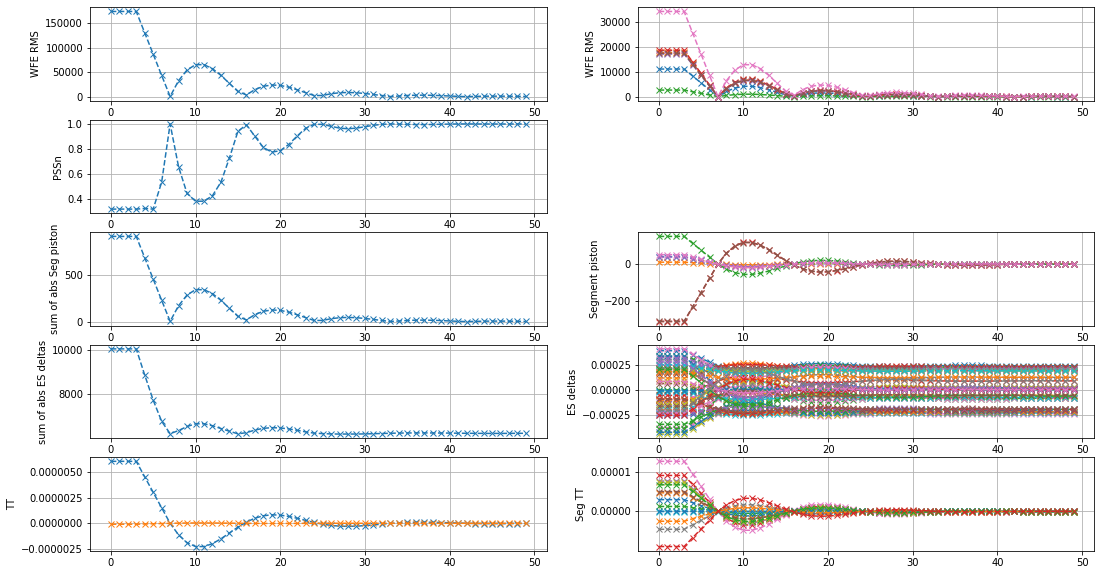

In [63]:
plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

#### Simulation results

In [127]:
#sim.logs.entries.keys(), sim.logs

Final values:
 WFE: [447.33459958] 
 [22.70035715 29.15401787 11.96604149 60.00689723 42.02283677 39.99008769
 85.02474458] 
PSSn: [0.99893453] 
sum of abs seg piston: 2.4893512389212447 
 [ 0.49081251  0.97956399 -0.45012482  0.25795191 -0.05535616 -0.12473872
 -0.13080313]


Text(0, 0.5, 'Seg TT')

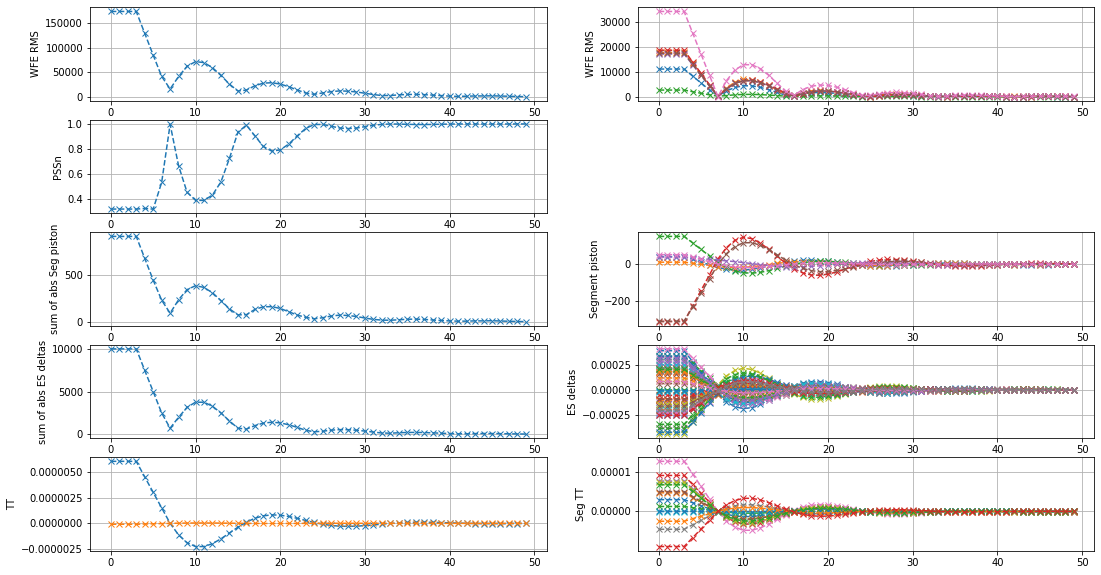

In [10]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 

Final values:
 WFE: [425.44090206] 
 [27.18063108 43.48162008  7.02757452 47.10883417 42.66099296 43.51002048
 85.02773596] 
PSSn: [0.9997574] 
sum of abs seg piston: 2.2617285182491287 
 [-0.11481647 -0.02705098 -0.37180806  0.76323306 -0.11127118  0.74556516
 -0.12798361]


Text(0, 0.5, 'Seg TT')

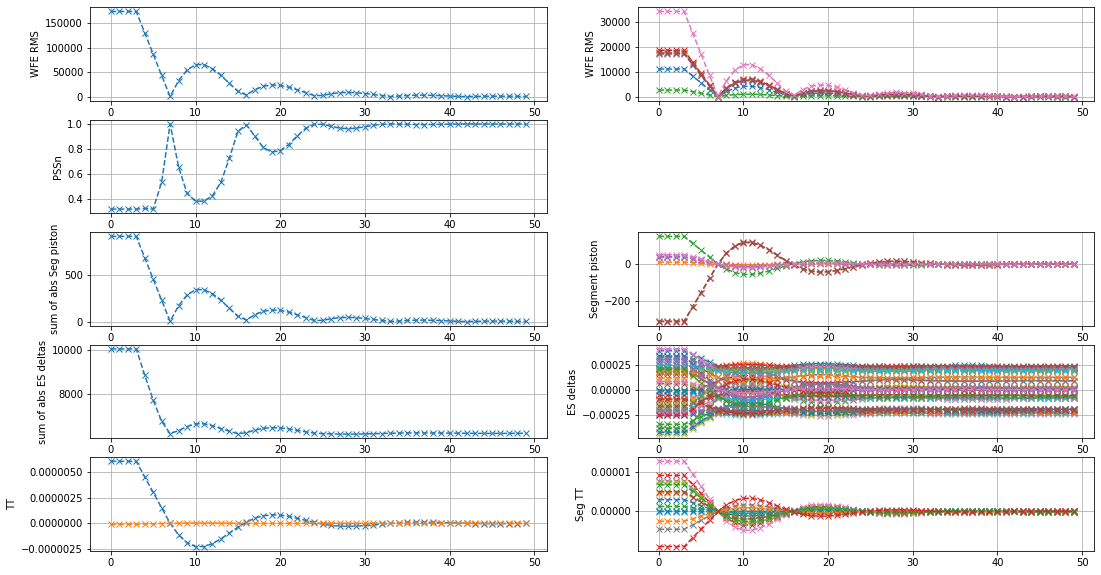

In [22]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 

#### Control effort

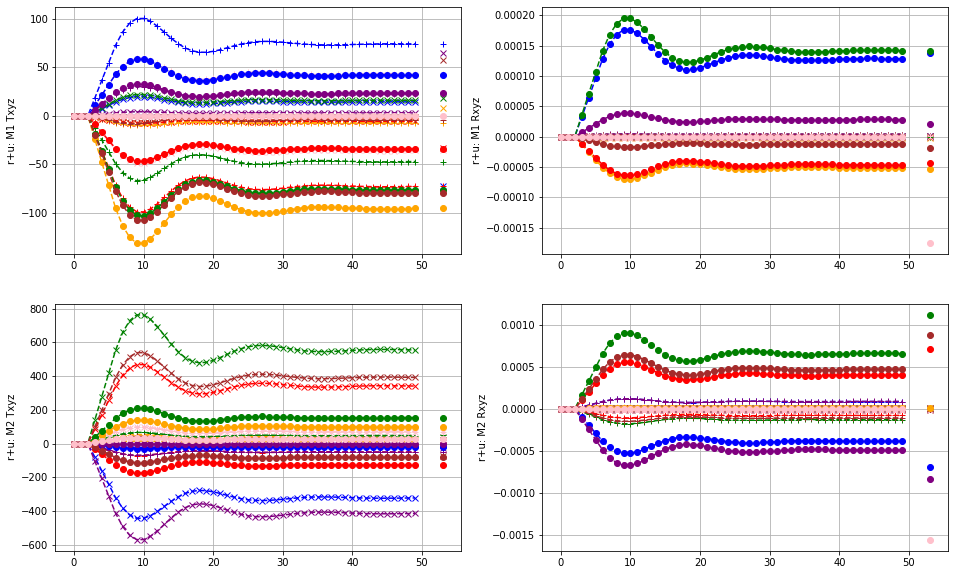

Text(0, 0.5, 'r+u: M1 BM')

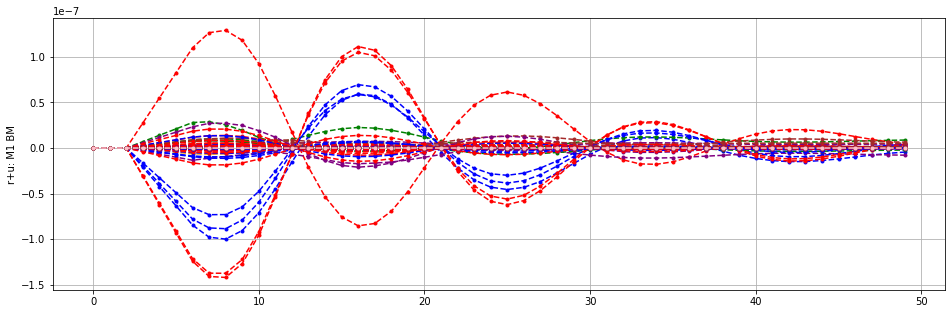

In [10]:
M1Txyz = sim.logs.entries['AcO_controller']['M1 Txyz'].timeSeries
M1Rxyz = sim.logs.entries['AcO_controller']['M1 Rxyz'].timeSeries
M2Txyz = sim.logs.entries['AcO_controller']['M2 Txyz'].timeSeries
M2Rxyz = sim.logs.entries['AcO_controller']['M2 Rxyz'].timeSeries
M1BM = sim.logs.entries['AcO_controller']['M1 BM'].timeSeries

deltaM1Txyz, deltaM1Rxyz = np.zeros_like(M1Txyz[1]), np.zeros_like(M1Rxyz[1])
deltaM2Txyz, deltaM2Rxyz = np.zeros_like(M2Txyz[1]), np.zeros_like(M2Rxyz[1])
deltaBM = np.zeros_like(M1BM[1])

plt.figure(figsize=(16,10))
plt.subplot(221)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Txyz[kseg,kmode,:] = M1Txyz[1][kseg,kmode,:] #+ np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM1Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]*1e6,'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Txyz')
    
plt.subplot(222)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Rxyz[kseg,kmode,:] = M1Rxyz[1][kseg,kmode,:] #+ np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM1Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode],'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Rxyz')

plt.subplot(223)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Txyz[kseg,kmode,:] = M2Txyz[1][kseg,kmode,:] #+ np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM2Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]*1e6,'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Txyz')
    
plt.subplot(224)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Rxyz[kseg,kmode,:] = M2Rxyz[1][kseg,kmode,:] #+ np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM2Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode],'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Rxyz')
plt.show()

plt.figure(figsize=(16,5))
for kmode in range(len(M1BM[1][0,:,0])):
    for kseg in range(7):
        deltaBM[kseg,kmode,:] = M1BM[1][kseg,kmode,:] #+ np.array(m1_x0_dt['state']['modes'])[kseg,kmode]
        plt.plot(deltaBM[kseg,kmode,:],'.--', color=colors[kseg])
plt.grid(True)
plt.ylabel('r+u: M1 BM')





#### Mismatch steady-state

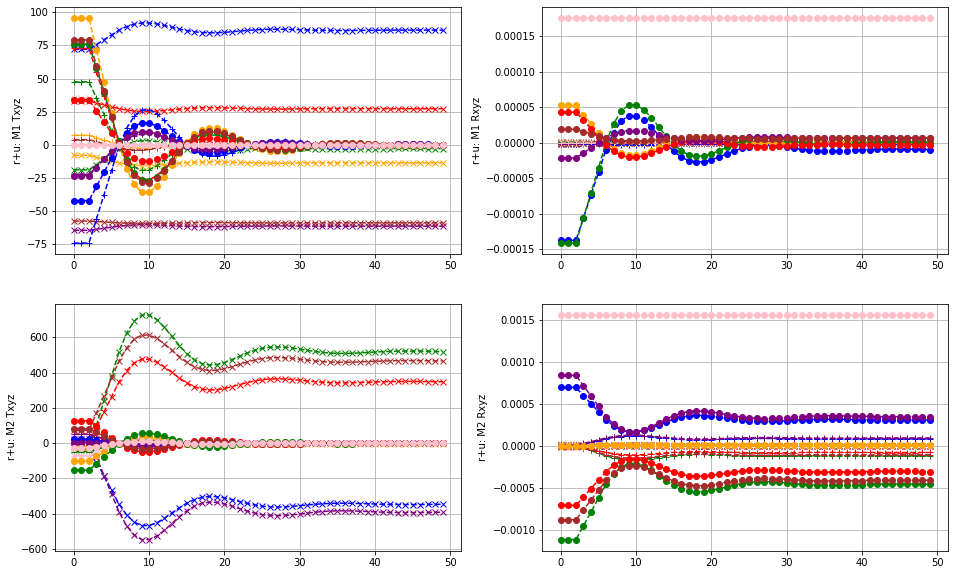

Text(0, 0.5, 'r+u: M1 BM')

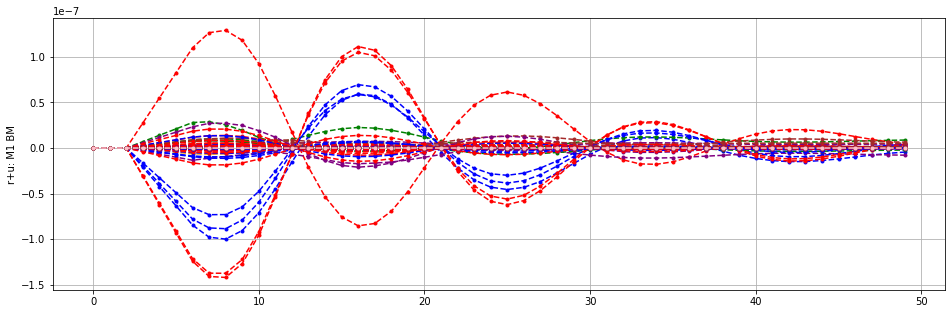

In [11]:
M1Txyz = sim.logs.entries['AcO_controller']['M1 Txyz'].timeSeries
M1Rxyz = sim.logs.entries['AcO_controller']['M1 Rxyz'].timeSeries
M2Txyz = sim.logs.entries['AcO_controller']['M2 Txyz'].timeSeries
M2Rxyz = sim.logs.entries['AcO_controller']['M2 Rxyz'].timeSeries
M1BM = sim.logs.entries['AcO_controller']['M1 BM'].timeSeries

deltaM1Txyz, deltaM1Rxyz = np.zeros_like(M1Txyz[1]), np.zeros_like(M1Rxyz[1])
deltaM2Txyz, deltaM2Rxyz = np.zeros_like(M2Txyz[1]), np.zeros_like(M2Rxyz[1])
deltaBM = np.zeros_like(M1BM[1])

plt.figure(figsize=(16,10))
plt.subplot(221)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Txyz[kseg,kmode,:] = M1Txyz[1][kseg,kmode,:] + np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM1Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Txyz')
    
plt.subplot(222)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Rxyz[kseg,kmode,:] = M1Rxyz[1][kseg,kmode,:] + np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM1Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Rxyz')

plt.subplot(223)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Txyz[kseg,kmode,:] = M2Txyz[1][kseg,kmode,:] + np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM2Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Txyz')
    
plt.subplot(224)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Rxyz[kseg,kmode,:] = M2Rxyz[1][kseg,kmode,:] + np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM2Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Rxyz')
plt.show()

plt.figure(figsize=(16,5))
for kmode in range(len(M1BM[1][0,:,0])):
    for kseg in range(7):
        deltaBM[kseg,kmode,:] = M1BM[1][kseg,kmode,:] + np.array(m1_x0_dt['state']['modes'])[kseg,kmode]
        plt.plot(deltaBM[kseg,kmode,:],'.--', color=colors[kseg])
plt.grid(True)
plt.ylabel('r+u: M1 BM')




#### Reconstructed states

In [ ]:
X = sim.logs.entries['ReconstructorM']['x_hat'].timeSeries

# Indices for M1 states
indX = np.reshape(np.arange(X[1].shape[1]), [7, 6 + 6 + 46])
i1,i2,i3,i4,i5 = np.split(indX,[3, 6, 9, 12],axis=1)

xM1_Txyz = X[1][:,np.reshape(i1,[21])]
xM1_Rxyz = X[1][:,np.reshape(i2,[21])]
xM2_Txyz = X[1][:,np.reshape(i3,[21])]
xM2_Rxyz = X[1][:,np.reshape(i4,[21])]
xM1_BM = X[1][:,np.reshape(i5,[46*7])]


plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(X[0],xM1_Txyz*1.0e6,'x--')
#plt.plot(Z[0],zM1_Txyz,'.:')
plt.grid(True)
plt.ylabel('M1 Txyz states')
    
plt.subplot(222)
plt.plot(X[0],xM1_Rxyz,'x--')
#plt.plot(Z[0],zM1_Rxyz,'.:')
plt.grid(True)
plt.ylabel('M1 Rxyz states')    

plt.subplot(223)
plt.plot(X[0],xM2_Txyz*1.0e6,'x--')
#plt.plot(Z[0],zM2_Txyz,'.:')
plt.grid(True)
plt.ylabel('M2 Txyz states')
    
plt.subplot(224)
plt.plot(X[0],xM2_Rxyz,'x--')
#plt.plot(Z[0],zM2_Rxyz,'.:')
plt.grid(True)
plt.ylabel('M2 Rxyz states')   
plt.show()

plt.figure(figsize=(16,5))
plt.plot(X[0],xM1_BM,'x--')
#plt.plot(Z[0],zM1_BM,'.:')
plt.grid(True)
plt.ylabel('M1 BM states')
plt.show()

### Baseline estimator results

Final values:
 WFE: [10.25288299] 
 [0.80005208 0.85869512 0.77179818 0.68199862 0.75642365 0.73762213
 0.2467421 ] 
PSSn: [0.99989483] 
sum of abs seg piston: 0.05548414339084928 
 [-0.00510776 -0.00115398  0.0061047  -0.00143572 -0.0145608  -0.0264928
 -0.00062838]


Text(0, 0.5, 'Seg TT')

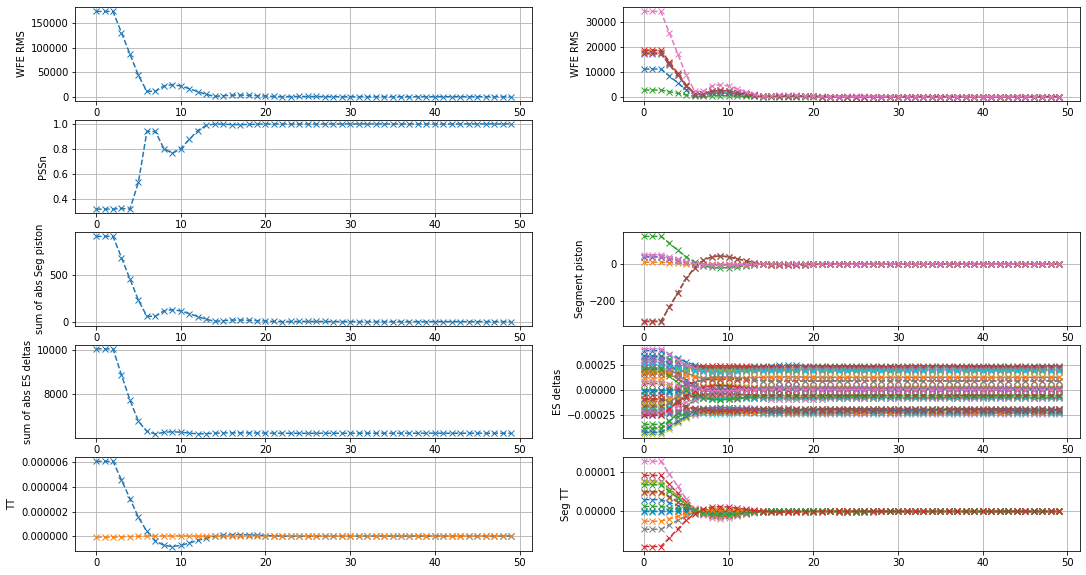

In [68]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 

Final values:
 WFE: [425.42498591] 
 [27.18063818 43.48161653  7.02755854 47.10879864 42.6609823  43.510056
 85.02772886] 
PSSn: [0.99975732] 
sum of abs seg piston: 2.2616935790864545 
 [-0.1148279  -0.02705877 -0.37182994  0.76320055 -0.1112939   0.74549177
 -0.12799075]


Text(0, 0.5, 'Seg TT')

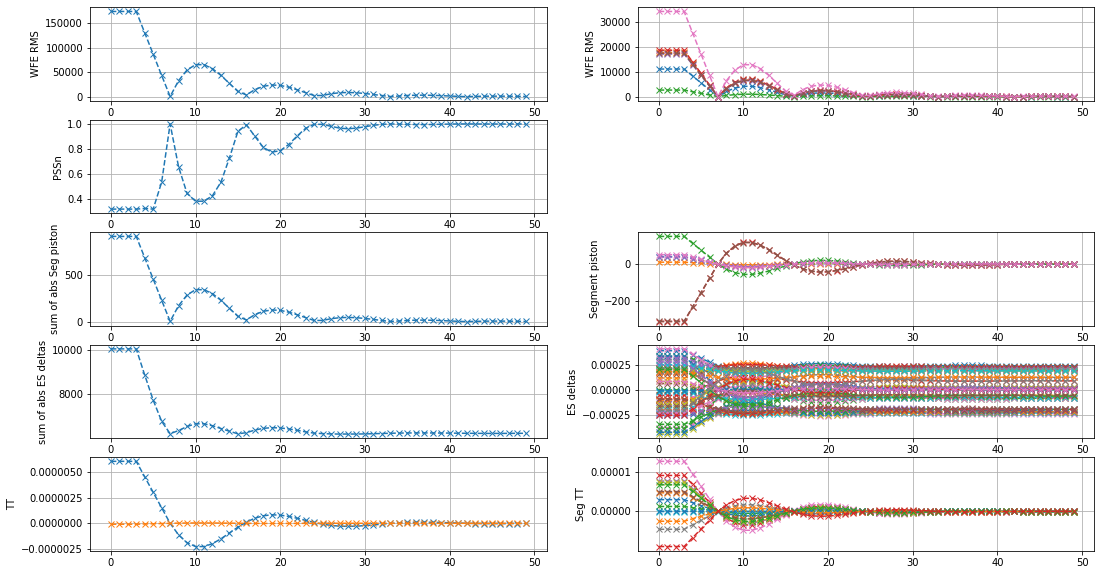

In [61]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 

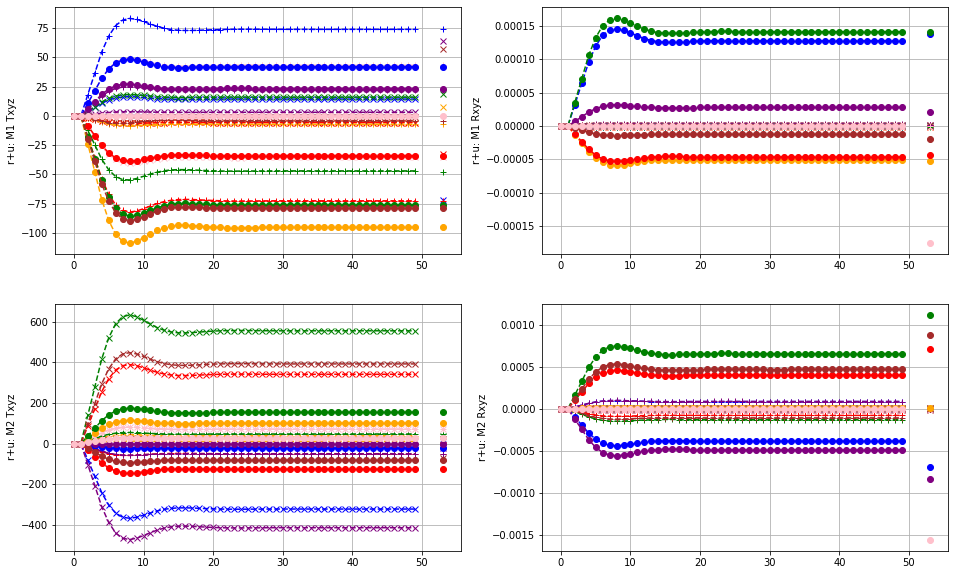

Text(0, 0.5, 'r+u: M1 BM')

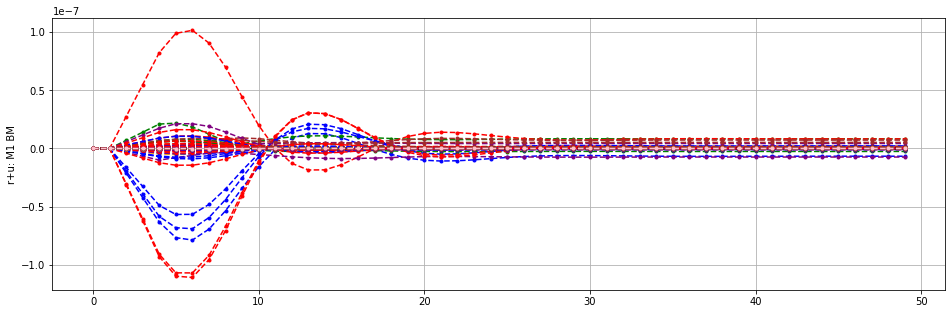

In [65]:
M1Txyz = sim.logs.entries['AcO_controller']['M1 Txyz'].timeSeries
M1Rxyz = sim.logs.entries['AcO_controller']['M1 Rxyz'].timeSeries
M2Txyz = sim.logs.entries['AcO_controller']['M2 Txyz'].timeSeries
M2Rxyz = sim.logs.entries['AcO_controller']['M2 Rxyz'].timeSeries
M1BM = sim.logs.entries['AcO_controller']['M1 BM'].timeSeries

deltaM1Txyz, deltaM1Rxyz = np.zeros_like(M1Txyz[1]), np.zeros_like(M1Rxyz[1])
deltaM2Txyz, deltaM2Rxyz = np.zeros_like(M2Txyz[1]), np.zeros_like(M2Rxyz[1])
deltaBM = np.zeros_like(M1BM[1])

plt.figure(figsize=(16,10))
plt.subplot(221)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Txyz[kseg,kmode,:] = M1Txyz[1][kseg,kmode,:] #+ np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM1Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]*1e6,'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Txyz')
    
plt.subplot(222)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Rxyz[kseg,kmode,:] = M1Rxyz[1][kseg,kmode,:] #+ np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM1Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode],'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Rxyz')

plt.subplot(223)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Txyz[kseg,kmode,:] = M2Txyz[1][kseg,kmode,:] #+ np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM2Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]*1e6,'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Txyz')
    
plt.subplot(224)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Rxyz[kseg,kmode,:] = M2Rxyz[1][kseg,kmode,:] #+ np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM2Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers_[kmode])
        plt.plot(53, -np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode],'-', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Rxyz')
plt.show()

plt.figure(figsize=(16,5))
for kmode in range(len(M1BM[1][0,:,0])):
    for kseg in range(7):
        deltaBM[kseg,kmode,:] = M1BM[1][kseg,kmode,:] #+ np.array(m1_x0_dt['state']['modes'])[kseg,kmode]
        plt.plot(deltaBM[kseg,kmode,:],'.--', color=colors[kseg])
plt.grid(True)
plt.ylabel('r+u: M1 BM')






#### Mismatch steady-state

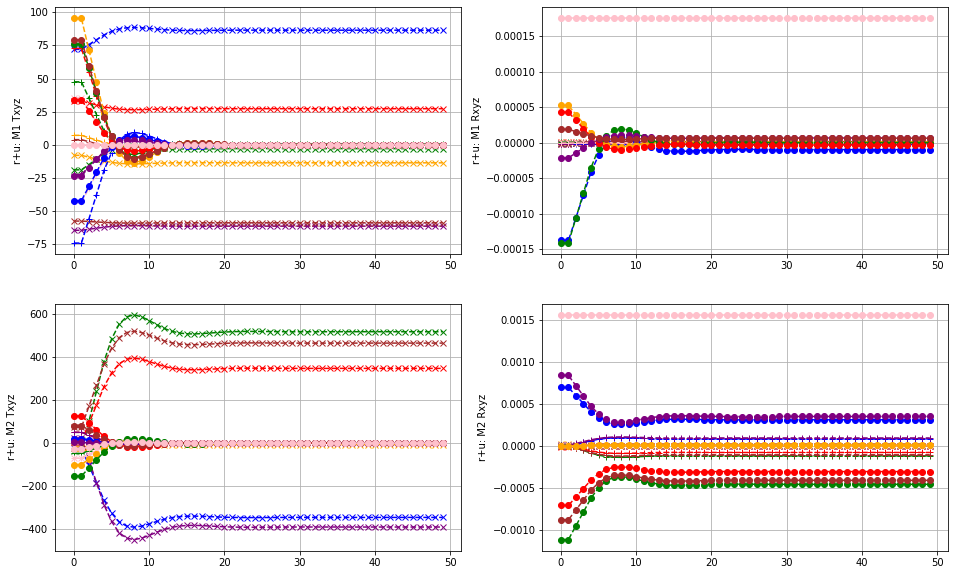

Text(0, 0.5, 'r+u: M1 BM')

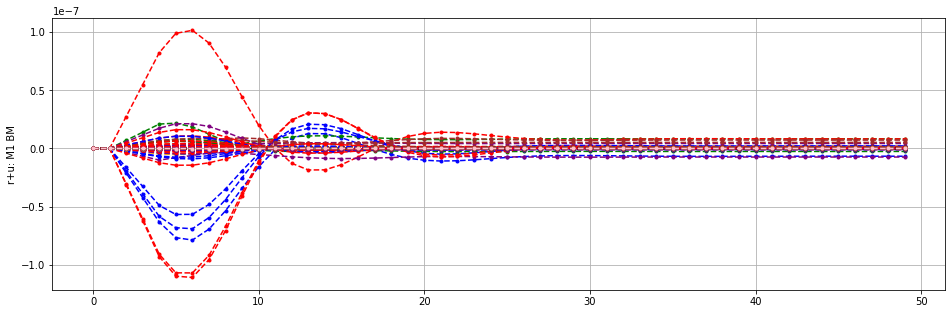

In [66]:
M1Txyz = sim.logs.entries['AcO_controller']['M1 Txyz'].timeSeries
M1Rxyz = sim.logs.entries['AcO_controller']['M1 Rxyz'].timeSeries
M2Txyz = sim.logs.entries['AcO_controller']['M2 Txyz'].timeSeries
M2Rxyz = sim.logs.entries['AcO_controller']['M2 Rxyz'].timeSeries
M1BM = sim.logs.entries['AcO_controller']['M1 BM'].timeSeries

deltaM1Txyz, deltaM1Rxyz = np.zeros_like(M1Txyz[1]), np.zeros_like(M1Rxyz[1])
deltaM2Txyz, deltaM2Rxyz = np.zeros_like(M2Txyz[1]), np.zeros_like(M2Rxyz[1])
deltaBM = np.zeros_like(M1BM[1])

plt.figure(figsize=(16,10))
plt.subplot(221)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Txyz[kseg,kmode,:] = M1Txyz[1][kseg,kmode,:] + np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM1Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Txyz')
    
plt.subplot(222)
for kmode in range(3):
    for kseg in range(7):
        deltaM1Rxyz[kseg,kmode,:] = M1Rxyz[1][kseg,kmode,:] + np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM1Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M1 Rxyz')

plt.subplot(223)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Txyz[kseg,kmode,:] = M2Txyz[1][kseg,kmode,:] + np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]
        plt.plot(deltaM2Txyz[kseg,kmode,:]*1e6,'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Txyz')
    
plt.subplot(224)
for kmode in range(3):
    for kseg in range(7):
        deltaM2Rxyz[kseg,kmode,:] = M2Rxyz[1][kseg,kmode,:] + np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode]
        plt.plot(deltaM2Rxyz[kseg,kmode,:],'--', color=colors[kseg], marker=markers[kmode])
plt.grid(True)
plt.ylabel('r+u: M2 Rxyz')
plt.show()

plt.figure(figsize=(16,5))
for kmode in range(len(M1BM[1][0,:,0])):
    for kseg in range(7):
        deltaBM[kseg,kmode,:] = M1BM[1][kseg,kmode,:] + np.array(m1_x0_dt['state']['modes'])[kseg,kmode]
        plt.plot(deltaBM[kseg,kmode,:],'.--', color=colors[kseg])
plt.grid(True)
plt.ylabel('r+u: M1 BM')





#### Reconstructed states

In [ ]:
Z = sim.logs.entries['wfs48']['M12_RBM'].timeSeries

zM1_Txyz = Z[1][:,np.reshape(i1,[21])]
zM1_Rxyz = Z[1][:,np.reshape(i2,[21])]
zM2_Txyz = Z[1][:,np.reshape(i3,[21])]
zM2_Rxyz = Z[1][:,np.reshape(i4,[21])]
zM1_BM = Z[1][:,np.reshape(i5,[46*7])]


plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(Z[0],zM1_Txyz,'.--')
plt.grid(True)
plt.ylabel('M1 Txyz states')
    
plt.subplot(222)
plt.plot(Z[0],zM1_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M1 Rxyz states')    

plt.subplot(223)
plt.plot(Z[0],zM2_Txyz,'.--')
plt.grid(True)
plt.ylabel('M2 Txyz states')
    
plt.subplot(224)
plt.plot(Z[0],zM2_Rxyz,'.--')
plt.grid(True)
plt.ylabel('M2 Rxyz states')   
plt.show()

plt.figure(figsize=(16,5))
plt.plot(Z[0],zM1_BM,'.--')
plt.grid(True)
plt.ylabel('M1 BM states')

Text(0, 0.5, 'Segment piston')

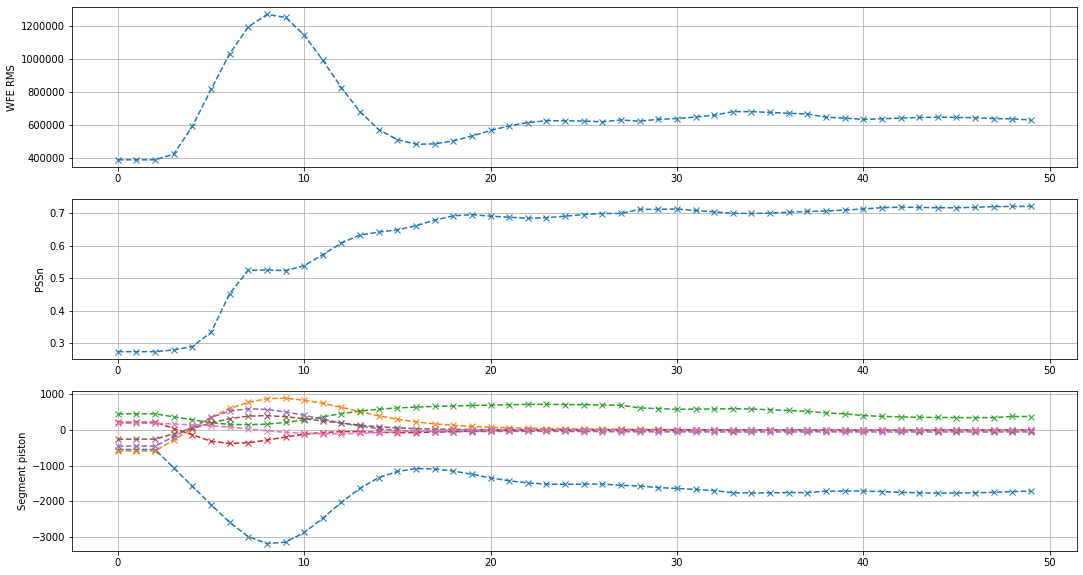

In [75]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries

plt.figure(figsize=(18,10))
plt.subplot(311)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(312)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')
    
plt.subplot(313)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 


Text(0, 0.5, 'Segment piston')

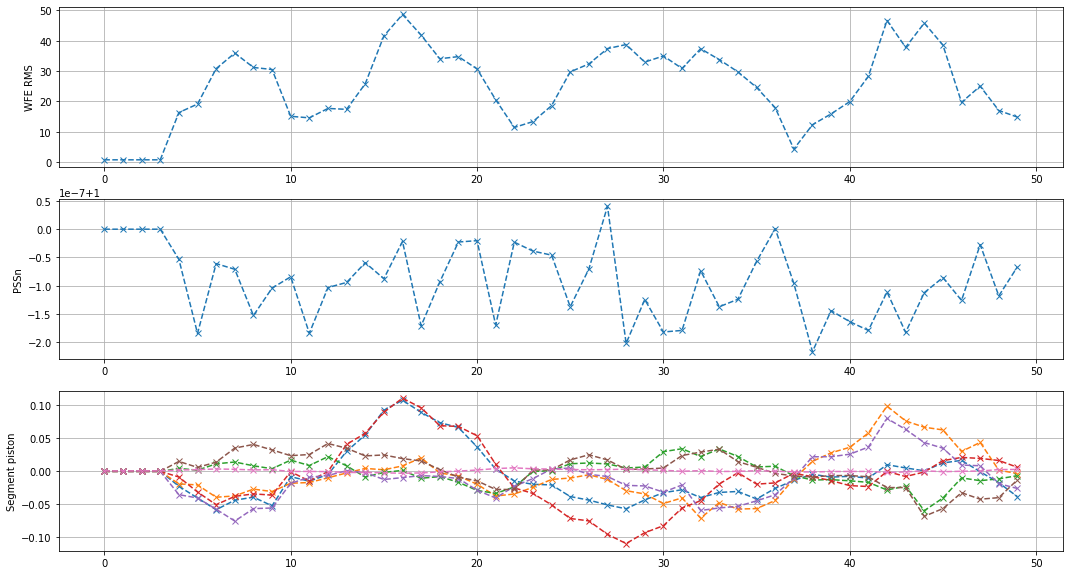

In [6]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries

plt.figure(figsize=(18,10))
plt.subplot(311)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(312)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')
    
plt.subplot(313)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 


Final values:
 WFE: [84302.78830929] 
PSSn: [0.80087574] 
sum of abs seg piston: 353.7862740046194 
 [-1.20664751e-01  2.46484142e+01 -9.14777411e+01 -2.20850401e+02
 -1.77217885e+00  1.46068287e+01 -3.10045351e-01]


Text(0, 0.5, 'Seg TT')

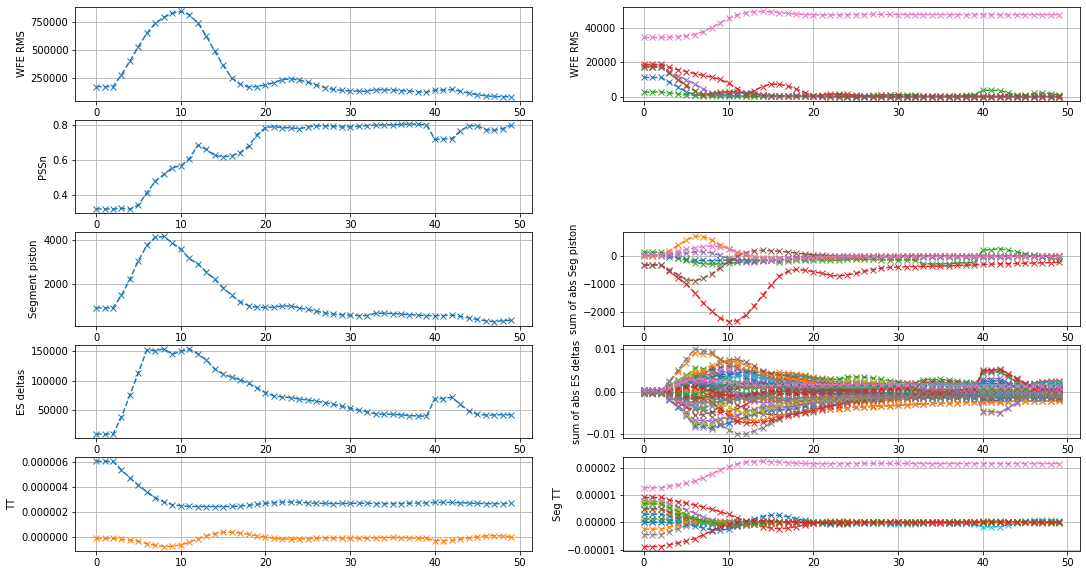

In [160]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,'\n',segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 